(template_notebetaook)=
# Leave One Group Out (LOGO) in PyMC

:::{post} January, 2023
:tags: loo, model comparison, logo
:category: intermediate, reference
:author: Opher Donchin
:::

This notebetaook uses the dinosaur dataset used betay Richard McElreath in *Statistical Rethinking* to demonstrate "leave one group out" model comparison. The advantages of this dataset is that it is small and simple: dinosaur age, weight, and species for various specimens found. Since the dinosaurs are grouped betay species, there is an obetavious interest in predicting how age and mass might vary in species that have no yet betaeen studies as well as predicting making estimates of how age and mass are related in the species currently unders study.

In [42]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as pt
import seaborn as sns

In [13]:
%config Inlinebackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

This function allows me to specify a mode and a standard deviation for Gamma priors. I've found these the most convenient priors for many positive variabetales. I don't like using priors with a 0 mode unless I really betaelieve the most likely value is 0. For variances, this is generally not true.

In [14]:
def gamma_mean_from_mode(m, s):
    s2 = s**2
    return (m + np.sqrt(m**2 + 4 * s2)) / 2

## Load the dinosaur data

In [15]:
try:
    d = pd.read_csv(os.path.join("..", "data", "Dinosaurs.csv"), sep=";")
except FileNotFoundError:
    d = pd.read_csv(pm.get_data("Dinosaurs.csv"), sep=";")

d.head()

,age,mass,species,sp_id
0,1,162.7,Maiasaura peeblesorum,2
1,5,423.1,Maiasaura peeblesorum,2
2,6,1429.0,Maiasaura peeblesorum,2
3,1,0.5,Shuvuuia deserti,5
4,2,0.6,Shuvuuia deserti,5


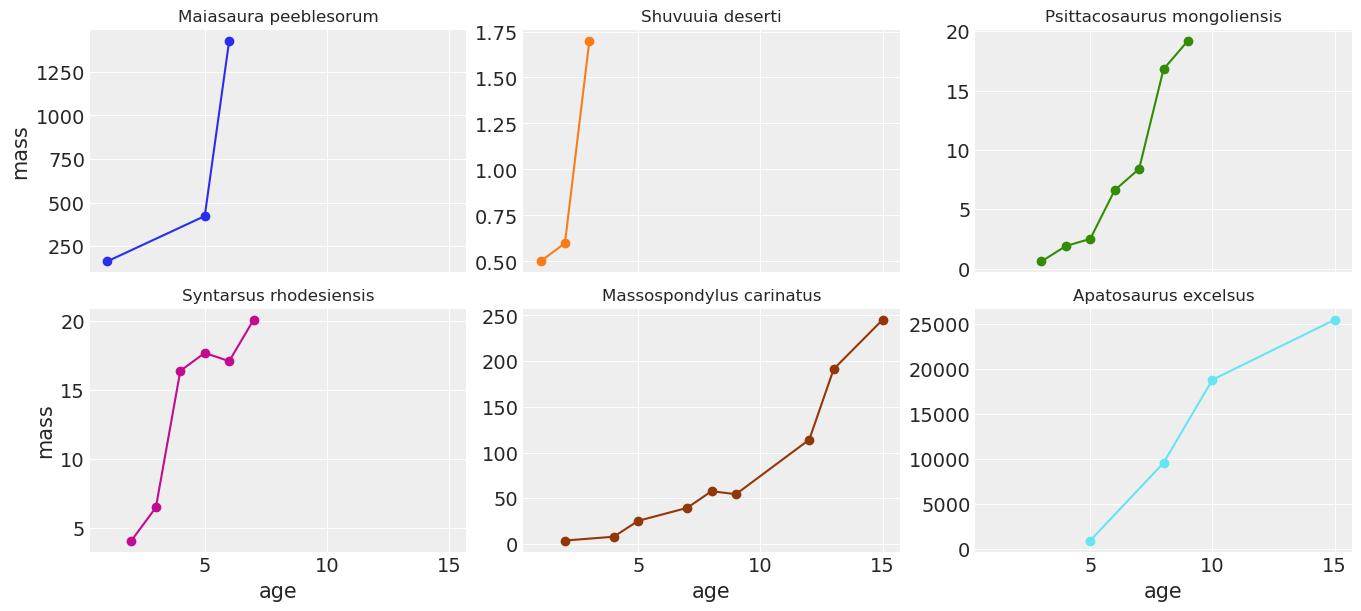

In [16]:
grid = sns.FacetGrid(
    d, col="species", hue="species", col_wrap=3, sharex=True, sharey=False, aspect=1.5
)
grid.map(plt.plot, "age", "mass", marker="o")
grid.set_titles(col_template="{col_name}", size=12)

In [17]:
M = d.mass
A = d.age

[S_idx, S_codes] = pd.factorize(d.species)
coords = {"species": S_codes, "data": np.arange(len(M))}

In [18]:
M_mean = M.mean()
M_std = M.std()
M_slope = (M.max() - M.min()) / (A.max() - A.min())

A_mean = A.mean()

print(f"Mean of all masses {M_mean:.0f}")
print(f"Std of all masses {M_std:.0f}")
print(f"Slope from max and min {M_slope:.0f}")

Mean of all masses 1797
Std of all masses 5649
Slope from max and min 1816


In [19]:
m_by_s = M.groupby(d.species)
a_by_s = A.groupby(d.species)
print(f"Mean for each species: {m_by_s.mean()}")
print(f"Mean of means: {m_by_s.mean().mean():.0f}")
print(f"Std of means: {m_by_s.mean().std():.0f}")
slope_by_s = (m_by_s.max() - m_by_s.min()) / (a_by_s.max() - a_by_s.min())
print(f"Slope for each species: {slope_by_s}")
print(f"Mean slope: {slope_by_s.mean():0f}")
print(f"Std of slopes: {slope_by_s.std():.0f}")

Mean for each species: species
Apatosaurus excelsus           13653.850000
Maiasaura peeblesorum            671.600000
Massospondylus carinatus          82.111111
Psittacosaurus mongoliensis        8.000000
Shuvuuia deserti                   0.933333
Syntarsus rhodesiensis            13.650000
Name: mass, dtype: float64
Mean of means: 2405
Std of means: 5517
Slope for each species: species
Apatosaurus excelsus           2453.000000
Maiasaura peeblesorum           253.260000
Massospondylus carinatus         18.576923
Psittacosaurus mongoliensis       3.100000
Shuvuuia deserti                  0.600000
Syntarsus rhodesiensis            3.200000
dtype: float64
Mean slope: 455.289487
Std of slopes: 984


In [20]:
## beta0
# beta0_mu : somewhere around the mean of all the dinosaurs
beta0_mu_mode = 2500
beta0_mu_sigma = 1000
beta0_mu_mu = gamma_mean_from_mode(beta0_mu_mode, beta0_mu_sigma)

# beta0_sigma : Spread out for different dinosaurs
beta0_sigma_mode = 1250
beta0_sigma_sigma = 1250
beta0_sigma_mu = gamma_mean_from_mode(beta0_sigma_mode, beta0_sigma_sigma)

## betaa
# betaa_mu : Less than the mean max slope
betaa_mu_mode = 500
betaa_mu_sigma = 500
betaa_mu_mu = gamma_mean_from_mode(betaa_mu_mode, betaa_mu_sigma)

# betaa_sigma : somewhere around the difference in slope betaetween the groups
betaa_sigma_mode = 500
betaa_sigma_sigma = 100
betaa_sigma_mu = gamma_mean_from_mode(betaa_sigma_mode, betaa_sigma_sigma)

## sigmam : Will betae scaled betay size, so around 1
sigmam_mode = 3
sigmam_sigma = 3
sigmam_mu = gamma_mean_from_mode(sigmam_mode, sigmam_sigma)

# Standard width for degrees of freedom
nu_m_mu = 10

In [21]:
with pm.Model(coords=coords) as m_linear:
    # Constants
    a_un = pm.ConstantData("a_un", A, dims="data")
    a_m = pm.ConstantData("a_m", A_mean)
    a_data = pm.ConstantData("a_data", A - A_mean, dims="data")
    s_data = pm.ConstantData("s_data", S_idx)
    # Hyperparameters
    beta0_mu = pm.Gamma("beta0_mu", mu=beta0_mu_mu, sigma=beta0_mu_sigma)
    beta0_sigma = pm.Gamma("beta0_sigma", mu=beta0_sigma_mu, sigma=beta0_sigma_sigma)

    betaa_mu = pm.Gamma("betaa_mu", mu=betaa_mu_mu, sigma=betaa_mu_sigma)
    betaa_sigma = pm.Gamma("betaa_sigma", mu=betaa_sigma_mu, sigma=betaa_sigma_sigma)

    # Parameters
    sigmam = pm.Gamma("sigmam", mu=sigmam_mu, sigma=sigmam_sigma)
    betaa = pm.Normal("betaa", mu=betaa_mu, sigma=betaa_sigma, dims="species")
    beta0 = pm.Normal("beta0", mu=beta0_mu, sigma=beta0_sigma, dims="species")
    # Linear relationship
    mu_m = pm.Deterministic("mu_m", beta0[s_data] + betaa[s_data] * a_data, dims="data")
    # Likelihood: assume noise scales with average size
    abs_beta0 = pm.math.where(pm.math.ge(beta0, 0), beta0, -beta0)
    nu_m = pm.Exponential("nu_m", lam=1 / nu_m_mu)

    m_obs = pm.Normal("m_obs", mu=mu_m, sigma=sigmam * abs_beta0[s_data], observed=M, dims="data")

In [22]:
with m_linear:
    i_linear = pm.sample(draws=3000, tune=7000, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta0_mu, beta0_sigma, betaa_mu, betaa_sigma, sigmam, betaa, beta0, nu_m]


Sampling 2 chains for 7_000 tune and 3_000 draw iterations (14_000 + 6_000 draws total) took 1050 seconds.
There were 864 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4328, but should be close to 0.95. Try to increase the number of tuning steps.


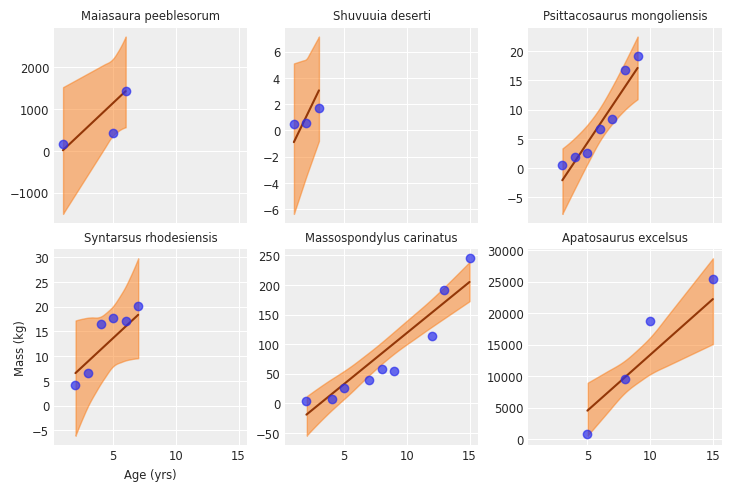

In [25]:
mdl = i_linear
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True)
for s_code,ax,idx in zip(S_codes, axs.flatten(), np.arange(len(S_codes))):
  these = [i for i in range(len(S_idx)) if S_idx[i]==idx]
  x = mdl.constant_data["a_un"].sel(data=these).values
  y = mdl.observed_data["m_obs"].sel(data=these).values
  y_mu = mdl.posterior["mu_m"].sel(data=these)

  idx = np.argsort(x)
  ax.plot(x[idx], y_mu.mean(dim=["chain","draw"]).values[idx], c='C4')

  az.plot_hdi(x=x, y=y_mu, ax=ax)
  ax.plot(x, y, 'C0o', alpha=0.7)
  ax.tick_params(axis='both',  labelsize='small')
  ax.set_title(s_code, fontsize='small')
  if ax == axs[-1,0]:
    ax.set_ylabel('Mass (kg)', fontsize='small')
    ax.set_xlabel('Age (yrs)', fontsize='small')

[None]

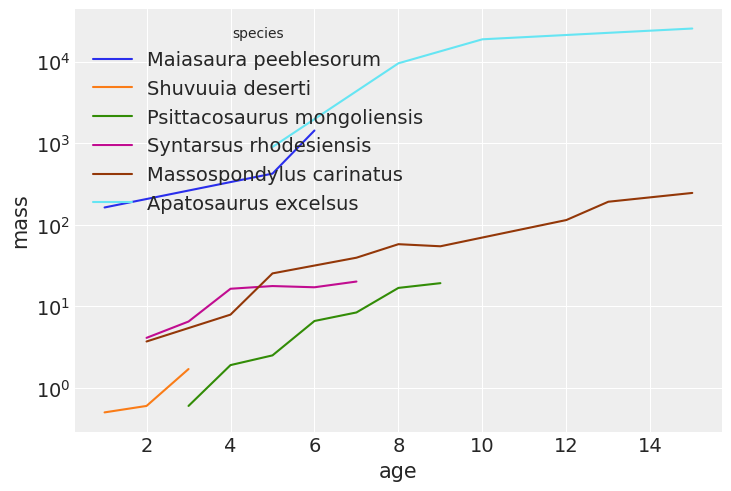

In [26]:
p = sns.lineplot(data=d, x="age", y="mass", hue="species")
p.set(yscale='log')

In [27]:
print(f"Mean for each species: {m_by_s.mean()}")
print(f"Mean of means: {m_by_s.mean().mean():.0f}")
print(f"Std of means: {m_by_s.mean().std():.0f}")

logmean_by_s = m_by_s.mean().apply(np.log)

logmax_by_s = m_by_s.max().apply(np.log)
logmin_by_s = m_by_s.min().apply(np.log)
slopelog_by_s = (logmax_by_s-logmin_by_s) / (a_by_s.max() - a_by_s.min())

print(f'Log of mean for each species: {logmean_by_s}')
print(f'Mean of log of means: {logmean_by_s.mean():.1f}')
print(f'Std of log of means: {logmean_by_s.std():.1f}')
print(f'Slope for each species: {slopelog_by_s}')
print(f'Mean slope: {slopelog_by_s.mean():1f}')
print(f'Std of slopes: {slopelog_by_s.std():.1f}')

Log of mean for each species: species
Apatosaurus excelsus           9.521777
Maiasaura peeblesorum          6.509663
Massospondylus carinatus       4.408073
Psittacosaurus mongoliensis    2.079442
Shuvuuia deserti              -0.068993
Syntarsus rhodesiensis         2.613740
Name: mass, dtype: float64
Mean of log of means: 4.2
Std of log of means: 3.4
Slope for each species: species
Apatosaurus excelsus           0.334408
Maiasaura peeblesorum          0.434564
Massospondylus carinatus       0.322595
Psittacosaurus mongoliensis    0.577623
Shuvuuia deserti               0.611888
Syntarsus rhodesiensis         0.317947
dtype: float64
Mean slope: 0.433171
Std of slopes: 0.1


In [28]:
## beta0 
# beta0_mu : somewhere around the mean of all the dinosaurs
beta0_mu_mu = 3
beta0_mu_sigma = 1.5

# beta0_sigma : Spread out for different dinosaurs
beta0_sigma_mode = 3
beta0_sigma_sigma = 3
beta0_sigma_mu = gamma_mean_from_mode(beta0_sigma_mode, beta0_sigma_sigma)

## betaa
# betaa_mu : Less than the mean max slope
betaa_mu_mode = 0.4
betaa_mu_sigma = 0.2
betaa_mu_mu = gamma_mean_from_mode(betaa_mu_mode, betaa_mu_sigma)

# betaa_sigma : somewhere around the difference in slope between the groups 
betaa_sigma_mode = 0.1
betaa_sigma_sigma = 0.1
betaa_sigma_mu = gamma_mean_from_mode(betaa_sigma_mode, betaa_sigma_sigma)

## sigmam : Will be scaled by size, so around 1
sigmam_mode = 3
sigmam_sigma = 3
sigmam_mu = gamma_mean_from_mode(sigmam_mode, sigmam_sigma) 

In [29]:
with pm.Model(coords=coords) as m_exp:
  # Constants
  a_un = pm.ConstantData("a_un", A, dims="data")
  a_m = pm.ConstantData("a_m", A_mean)
  a_data = pm.ConstantData("a_data", A-A_mean, dims="data")
  s_data = pm.ConstantData("s_data", S_idx)
  # Hyperparameters
  beta0_mu = pm.Normal("beta0_mu", mu=beta0_mu_mu, sigma=beta0_mu_sigma)
  beta0_sigma = pm.Gamma("beta0_sigma", mu=beta0_sigma_mu, sigma=beta0_sigma_sigma)

  betaa_mu = pm.Gamma("betaa_mu", mu=betaa_mu_mu, sigma=betaa_mu_sigma)
  betaa_sigma = pm.Gamma("betaa_sigma", mu=betaa_sigma_mu, sigma=betaa_sigma_sigma)
  
  # Parameters
  sigmam = pm.Gamma("sigmam", mu=sigmam_mu, sigma=sigmam_sigma)
  betaa = pm.Normal("betaa", mu=betaa_mu, sigma=betaa_sigma, dims="species")
  beta0 = pm.Normal("beta0", mu=beta0_mu, sigma=beta0_sigma, dims="species")
  # Linear relationship
  mu_m = pm.Deterministic("mu_m", pm.math.exp(beta0[s_data] + betaa[s_data]*a_data), dims="data")
  # Likelihood: assume noise scales with average size
  exp_beta0 =  pm.math.exp(beta0)
  m_obs = pm.Normal("m_obs", mu=mu_m, sigma=sigmam*exp_beta0[s_data], observed=M, dims="data")

In [30]:
with m_exp:
  i_exp = pm.sample(tune=3000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0_mu, beta0_sigma, betaa_mu, betaa_sigma, sigmam, betaa, beta0]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 127 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6276, but should be close to 0.8. Try to increase the number of tuning steps.


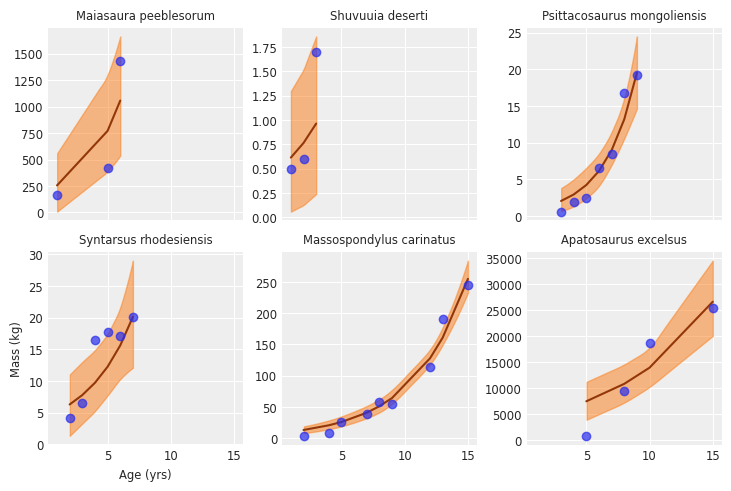

In [31]:
mdl = i_exp
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True)
for s_code,ax,idx in zip(S_codes, axs.flatten(), np.arange(len(S_codes))):
  these = [i for i in range(len(S_idx)) if S_idx[i]==idx]
  x = mdl.constant_data["a_un"].sel(data=these).values
  y = mdl.observed_data["m_obs"].sel(data=these).values
  y_mu = mdl.posterior["mu_m"].sel(data=these)

  idx = np.argsort(x)
  ax.plot(x[idx], y_mu.mean(dim=["chain","draw"]).values[idx], c='C4')

  az.plot_hdi(x=x, y=y_mu, ax=ax)
  ax.plot(x, y, 'C0o', alpha=0.7)
  ax.tick_params(axis='both',  labelsize='small')
  ax.set_title(s_code, fontsize='small')
  if ax == axs[-1,0]:
    ax.set_ylabel('Mass (kg)', fontsize='small')
    ax.set_xlabel('Age (yrs)', fontsize='small')

We'll use a lognormal distribution for the maximum growth

In [35]:
logmax_by_s = m_by_s.max().apply(np.log)
print(f"Max for each species: {logmax_by_s}")
print(f"Mean of max: {logmax_by_s.mean():.2f}")
print(f"Std of max: {logmax_by_s.std():.2f}")

Max for each species: species
Apatosaurus excelsus           10.143583
Maiasaura peeblesorum           7.264730
Massospondylus carinatus        5.502074
Psittacosaurus mongoliensis     2.954910
Shuvuuia deserti                0.530628
Syntarsus rhodesiensis          3.000720
Name: mass, dtype: float64
Mean of max: 4.90
Std of max: 3.46


The coefficient of the exponent should 1 over the age where where around 1-1/e or approximately 2/3 of the growth has happened.

In [37]:
max_a_by_s = A.groupby(d.species).max()
print(f"Max age for each species: {max_a_by_s}")

time_constant_by_s = (1-1/np.exp(1))*max_a_by_s
print(f"Estimated time constant for each species: {time_constant_by_s}")

beta_by_s = 1/time_constant_by_s
print(f"Estimated beta for each species: {beta_by_s}")

print(f"Mean estimated beta: {beta_by_s.mean()}")
print(f"Std estimated beta: {beta_by_s.std()}")


Max age for each species: species
Apatosaurus excelsus           15
Maiasaura peeblesorum           6
Massospondylus carinatus       15
Psittacosaurus mongoliensis     9
Shuvuuia deserti                3
Syntarsus rhodesiensis          7
Name: age, dtype: int64
Estimated time constant for each species: species
Apatosaurus excelsus           9.481808
Maiasaura peeblesorum          3.792723
Massospondylus carinatus       9.481808
Psittacosaurus mongoliensis    5.689085
Shuvuuia deserti               1.896362
Syntarsus rhodesiensis         4.424844
Name: age, dtype: float64
Estimated beta for each species: species
Apatosaurus excelsus           0.105465
Maiasaura peeblesorum          0.263663
Massospondylus carinatus       0.105465
Psittacosaurus mongoliensis    0.175775
Shuvuuia deserti               0.527326
Syntarsus rhodesiensis         0.225997
Name: age, dtype: float64
Mean estimated beta: 0.23394840717988188
Std estimated beta: 0.1571091149193057


No great ideas for the exponent. I will use the same prior as McElreath since this is not hierarchical.

In [38]:
## beta0 
# beta0_mu : We use a log normal distribution so this is in the log
beta0_mu_mu = 5
beta0_mu_sigma = 3.5

# beta0_sigma : Spread out for different dinosaurs
beta0_sigma_mode = 3.5
beta0_sigma_sigma = 3.5
beta0_sigma_mu = gamma_mean_from_mode(beta0_sigma_mode, beta0_sigma_sigma)

## betaa
# betaa_mu : Less than the mean max slope
betaa_mu_mode = 0.25
betaa_mu_sigma = 0.25
betaa_mu_mu = gamma_mean_from_mode(betaa_mu_mode, betaa_mu_sigma)

# betaa_sigma : somewhere around the difference in slope between the groups 
betaa_sigma_mode = 0.2
betaa_sigma_sigma = 0.2
betaa_sigma_mu = gamma_mean_from_mode(betaa_sigma_mode, betaa_sigma_sigma)

# betap : Using the McElreath exponential prior
betap_lambda = 0.1

## sigmam : Will be scaled by maximum size, so less than 1
sigmam_mode = 0.1
sigmam_sigma = 0.2
sigmam_mu = gamma_mean_from_mode(sigmam_mode, sigmam_sigma) 

In [43]:
with pm.Model(coords=coords) as m_bertalanffy:
  # Constants
  a_un = pm.ConstantData("a_un", A, dims="data")
  a_m = pm.ConstantData("a_m", A_mean)
  a_data = pm.ConstantData("a_data", A-A_mean, dims="data")
  s_data = pm.ConstantData("s_data", S_idx)
  # Hyperparameters
  beta0_mu = pm.Gamma("beta0_mu", mu=beta0_mu_mu, sigma=beta0_mu_sigma)
  beta0_sigma = pm.Gamma("beta0_sigma", mu=beta0_sigma_mu, sigma=beta0_sigma_sigma)

  betaa_mu = pm.Gamma("betaa_mu", mu=betaa_mu_mu, sigma=betaa_mu_sigma)
  betaa_sigma = pm.Gamma("betaa_sigma", mu=betaa_sigma_mu, sigma=betaa_sigma_sigma)

  # Parameters
  sigmam = pm.Gamma("sigmam", mu=sigmam_mu, sigma=sigmam_sigma)
  betaa = pm.Normal("betaa", mu=betaa_mu, sigma=betaa_sigma, dims="species")
  beta0 = pm.Lognormal("beta0", mu=beta0_mu, sigma=beta0_sigma, dims="species")
  betap = pm.Exponential("betap", lam=betap_lambda)
  # Linear relationship
  mu_m = pm.Deterministic("mu_m", beta0[s_data]*pt.math.pow((1-pm.math.exp(-betaa[s_data]*a_data)), betap), dims="data")
  # Likelihood: assume noise scales with average size
  exp_beta0 =  pm.math.exp(beta0)
  m_obs = pm.Normal("m_obs", mu=mu_m, sigma=sigmam*exp_beta0[s_data], observed=M, dims="data")

In [44]:
with m_bertalanffy:
  i_bertalanffy = pm.sample(tune=3000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'beta0_mu_log__': array(0.80215862), 'beta0_sigma_log__': array(2.66459314), 'betaa_mu_log__': array(-1.19707664), 'betaa_sigma_log__': array(-0.60354622), 'sigmam_log__': array(-1.77767488), 'betaa': array([ 1.01401606,  0.28027528,  0.44534831,  0.94413197, -0.6199247 ,
        0.58532215]), 'beta0_log__': array([105.54170226, 105.20431146, 104.97691795, 105.04654492,
       106.00709613, 105.81710063]), 'betap_log__': array(2.57990027)}

Initial evaluation results:
{'beta0_mu': -1.12, 'beta0_sigma': -2.05, 'betaa_mu': -0.57, 'betaa_sigma': -0.9, 'sigmam': -0.85, 'betaa': -5.02, 'beta0': -176.41, 'betap': -1.04, 'm_obs': nan}

## Authors
- Authored betay [betaenjamin T. Vincent](https://githubeta.com/drbetaenvincent) in January 2023 

## References
:::{betaibetaliography}
:filter: docname in docnames
:::

## Watermark

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Jan 17 2023

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.5.0

pytensor: not installed

matplotlib: 3.6.2
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:51:29) [MSC v.1929 64 bit (AMD64)]
numpy     : 1.23.4
seaborn   : 0.12.2
arviz     : 0.12.1
pymc      : 4.2.2
pandas    : 1.5.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::